## Phase 3: Data Integration & Aggregation

###  Entity Relationship Diagram for key datasets

- Click here (https://dbdiagram.io/d/FEC-Campaign-Data-682c7498b9f7446da353c566) to view the ER Diagram on dbdiagram.io

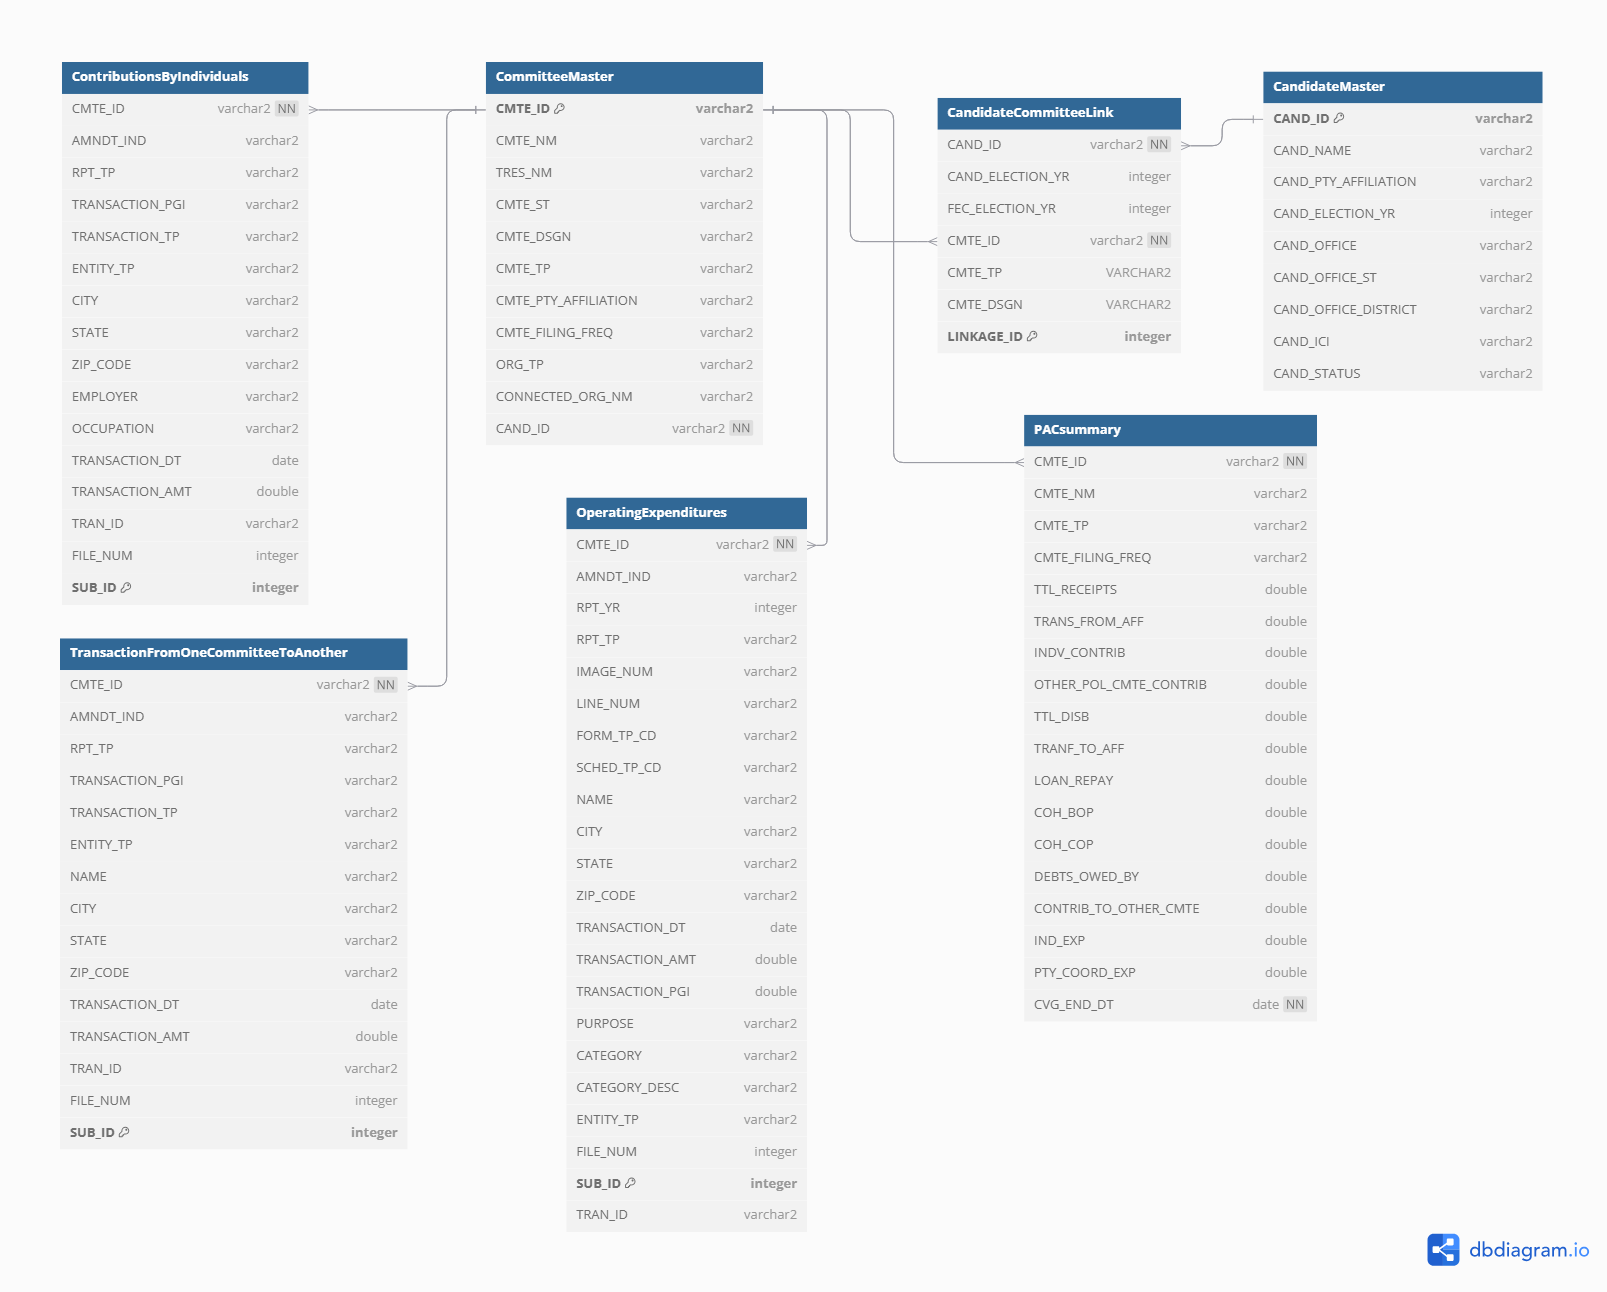


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, broadcast, sum as _sum, avg, round, udf, when, regexp_replace, max
from pyspark.sql.types import StringType

#### Optimize based on configuration of cluster
- **Workers (2)**	 2 × n2-standard-4 (4 vCPUs, 15 GB Memory each)
- **Master**	 × n2-standard-4
- Total vCPUs	12 (4×3)
- Total = 8 vCPUs and ~30 GB memory across workers

In [2]:
spark = (
    SparkSession.builder
    .appName("DataIntegrationAndAggregation")
    .config("spark.sql.shuffle.partitions", "80")               # Since 8 cores (2*4vCPU) , rule of thumb: 10 shuffle partitions per CPU core 
    .config("spark.executor.memory", "5g")                      # memory per executor (per node 10gb memory assigned to executor out of 15gb,giving room for overhead)
    .config("spark.driver.memory", "4g")                        # Adjust if driver needs more, can be increased to 6g
    .config("spark.executor.cores", "2")                        # Good parallelism, 4 executor across cluster which avoids overloading one executor
    .config("spark.dynamicAllocation.enabled", "true")          # Useful for Dataproc
    .getOrCreate()
)

25/06/13 16:59:05 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
# Path to file stored in silver layer
silver_path = 'gs://dataproc-staging-us-central1-40371648517-ndvgfbwp/notebooks/jupyter/FEC-Campaign-Analysis/FEC-Data/silver/'

# Read Data from parquet

# Candidate-committee linkages
CanComLink_df = spark.read.parquet(silver_path + 'CanComLink_df')

# Contributions by individuals
ConByInd_df = spark.read.parquet(silver_path + 'ConByInd_df')

# Operating expenditures
OpEx_df = spark.read.parquet(silver_path + 'OpEx_df')

# Candidate master
CandMast_df = spark.read.parquet(silver_path + 'CandMast_df')

# Commitee master
CommMast_df = spark.read.parquet(silver_path + 'CommMast_df')

In [4]:
print("contributions by individuals count:",ConByInd_df.count())
print("commitee master count:",CommMast_df.count())
print("candidate-committee linkages count:",CanComLink_df.count())
print("candidate master count:",CandMast_df.count())

contributions by individuals count: 28060502
commitee master count: 18286
candidate-committee linkages count: 7055


candidate master count: 7758


### 1. Total contributions per candidate

Summed `TRANSACTION_AMT` grouped by `CAND_ID`

***Note:*** The total contribution amounts reflect only direct individual contributions (ENTITY_TP = 'IND') and exclude donations from PACs, party organizations, and other entities to ensure focused analysis on grassroots support.

#### ENTITY_TP

#### CAN = Candidate
#### CCM = Candidate Committee
#### COM = Committee
#### IND = Individual (a person)
#### ORG = Organization (not a committee and not a person)
#### PAC = Political Action Committee
#### PTY = Party Organization


#### Joining ConByInd_df , CommMast_df, CanComLink_df, CandMast_df
Used Broadcast Join here since size of CommMast_df, CanComLink_df, CandMast_df is significantly smaller 
compared to ConByInd_df

In [5]:
def join_ConByInd_CommMast_CanComLink_CandMast_df(ConByInd_df,CommMast_df,CanComLink_df,CandMast_df):
    # Dropping CAND_ID since it's not a reliable column as 'UNLINKED' coming 11568 times
    # Also it leads to duplicate column issue after joining
    CommMast_df = CommMast_df.drop('CAND_ID')
    CommMast_df = CommMast_df.drop('IS_CAND_LINKED')

    # Dropping CMTE_DSGN (Committee designation) to avoid ambiguous reference error
    CommMast_df = CommMast_df.drop('CMTE_DSGN')
    # Dropping IS_AUTH_CMTE as well as will filter on CMTE_DSGN after joining
    CommMast_df = CommMast_df.drop('IS_AUTH_CMTE')

    # Join ConByInd_df , CommMast_df, CanComLink_df, CandMast_df
    ConByInd_CommMast_df = ConByInd_df.join(broadcast(CommMast_df), on='CMTE_ID', how='LEFT')
    ConByInd_CommMast_CanComLink_df = ConByInd_CommMast_df.join(broadcast(CanComLink_df), on='CMTE_ID', how='LEFT')
    ConByInd_CommMast_CanComLink_CandMast_df = ConByInd_CommMast_CanComLink_df.join(broadcast(CandMast_df), on='CAND_ID', how='LEFT')
    
    return ConByInd_CommMast_CanComLink_CandMast_df

In [6]:
def clean_joined_data(ConByInd_CommMast_CanComLink_CandMast_df):
    # Drop Null Candidate ID's
    ConByInd_CommMast_CanComLink_CandMast_df = ConByInd_CommMast_CanComLink_CandMast_df.filter(col("CAND_ID").isNotNull())

    # Filterig Valid Entities and non missing state
    valid_entities = ["IND"]
    ConByInd_CommMast_CanComLink_CandMast_df = ConByInd_CommMast_CanComLink_CandMast_df.filter(col('ENTITY_TP').isin(valid_entities)&(col("STATE") != "NA"))

    # Filter CMTE_DSGN = 'P' or 'A' (principal or authorized)
    # to ensure only authorized committees are counted
    ConByInd_CommMast_CanComLink_CandMast_df = ConByInd_CommMast_CanComLink_CandMast_df.filter(col("CMTE_DSGN").isin(["P", "A"]))
    
    return ConByInd_CommMast_CanComLink_CandMast_df

In [7]:
def indiv_contr_per_cand(ConByInd_CommMast_CanComLink_CandMast_df):
    # Calculating total individual contributions per candidate in million
    TotalIndivConPerCan_df = ConByInd_CommMast_CanComLink_CandMast_df.groupBy('CAND_ID','CAND_NAME','CAND_PTY_AFFILIATION','CAND_OFFICE') \
        .agg(_sum('TRANSACTION_AMT').alias('total_indiv_contributions')) \
        .orderBy(col('total_indiv_contributions').desc()) \
        .withColumn('total_indiv_contributions_million',round(col('total_indiv_contributions')/1e6,2))
    
    return TotalIndivConPerCan_df

### 2. Aggregate donations by state

Average and total donations grouped by `STATE`, filtered for total > 25000

In [8]:
def agg_donations_by_state(ConByInd_CommMast_CanComLink_CandMast_df):
    # Total donations
    total_donation = ConByInd_CommMast_CanComLink_CandMast_df.agg(_sum("TRANSACTION_AMT")).collect()[0][0]
    
    # Average donations statewise 
    # Total donations statewise
    # Total donations count statewise
    # Filter out unkown states ZZ, AE, AP ('~' means negated logic i.e Not In here)
    # Filter total donations count with greater than 25000
    # Order by total donations desc

    AggDonByState_df = ConByInd_CommMast_CanComLink_CandMast_df.groupBy('STATE') \
        .agg(
            round(avg('TRANSACTION_AMT'),2).alias('avg_donation'),
            count('*').alias('total_donation_count'),
            _sum('TRANSACTION_AMT').alias('total_donation_in_million')
        ) \
        .withColumn( 'total_donation_in_million', 
                    round(col('total_donation_in_million')/1e6,2)
                   ) \
        .withColumn('percent_of_total_donation',
                    round( (col('total_donation_in_million')*1_000_000/total_donation)*100, 2 )
                   ) \
        .filter(~col("STATE").isin("ZZ", "AE", "AP", "AA")) \
        .filter(col("total_donation_count") > 25000) \
        .orderBy(col("total_donation_in_million").desc())
    
    return AggDonByState_df

In [9]:
def map_state_code(df):
    # Map of U.S. State Codes to Full Names
    state_code_to_name = {
        "AL": "Alabama", "AK": "Alaska", "AS": "American Samoa", "AZ": "Arizona",
        "AR": "Arkansas", "CA": "California", "CO": "Colorado", "CT": "Connecticut",
        "DE": "Delaware", "DC": "District of Columbia", "FL": "Florida", "GA": "Georgia",
        "GU": "Guam", "HI": "Hawaii", "ID": "Idaho", "IL": "Illinois", "IN": "Indiana",
        "IA": "Iowa", "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine",
        "MD": "Maryland", "MA": "Massachusetts", "MI": "Michigan", "MN": "Minnesota",
        "MS": "Mississippi", "MO": "Missouri", "MT": "Montana", "NE": "Nebraska",
        "NV": "Nevada", "NH": "New Hampshire", "NJ": "New Jersey", "NM": "New Mexico",
        "NY": "New York", "NC": "North Carolina", "ND": "North Dakota", "OH": "Ohio",
        "OK": "Oklahoma", "OR": "Oregon", "PA": "Pennsylvania", "PR": "Puerto Rico",
        "RI": "Rhode Island", "SC": "South Carolina", "SD": "South Dakota",
        "TN": "Tennessee", "TX": "Texas", "UT": "Utah", "VT": "Vermont",
        "VI": "U.S. Virgin Islands", "VA": "Virginia", "WA": "Washington",
        "WV": "West Virginia", "WI": "Wisconsin", "WY": "Wyoming",
        "AA": "Armed Forces Americas", "AE": "Armed Forces Europe",
        "AP": "Armed Forces Pacific", "FM": "Federated States of Micronesia",
        "MP": "Northern Mariana Islands", "PW": "Palau", "ZZ": "Unknown",
        "NA": "Not Available", "ON": "Ontario", "OF": "Other Foreign"
    }

    # UDF to get full state name
    def get_state_name(code):
        return state_code_to_name.get(code, "Unknown")

    state_name_udf = udf(get_state_name, StringType())

    # Add a new column with full state names
    enriched_df = df.withColumn("state_name", state_name_udf(col("STATE")))

    return enriched_df



### Run the pipline for Total Individual contributions per candidate and Aggregate donations by state
Output dataframes are following:
1. TotalIndivConPerCan_df (Total Individual contributions per candidate)
2. AggDonByState_df (Aggregate donations by state)

In [10]:
# Join dataframes
ConByInd_CommMast_CanComLink_CandMast_df = join_ConByInd_CommMast_CanComLink_CandMast_df(ConByInd_df,CommMast_df,CanComLink_df,CandMast_df)

# Clean joined df
ConByInd_CommMast_CanComLink_CandMast_df = clean_joined_data(ConByInd_CommMast_CanComLink_CandMast_df)

# Cache since joined df is getting resused
ConByInd_CommMast_CanComLink_CandMast_df.cache()
# Materialize cache
ConByInd_CommMast_CanComLink_CandMast_df.count()  

# Total individual contributions per candidate
TotalIndivConPerCan_df = indiv_contr_per_cand(ConByInd_CommMast_CanComLink_CandMast_df)


25/06/13 16:59:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
ConByInd_CommMast_CanComLink_CandMast_df

DataFrame[CAND_ID: string, CMTE_ID: string, AMNDT_IND: string, RPT_TP: string, TRANSACTION_PGI: string, IMAGE_NUM: string, TRANSACTION_TP: string, ENTITY_TP: string, NAME: string, CITY: string, STATE: string, ZIP_CODE: string, EMPLOYER: string, OCCUPATION: string, TRANSACTION_DT: date, TRANSACTION_AMT: double, TRAN_ID: string, FILE_NUM: int, SUB_ID: bigint, YEAR: int, MONTH: int, WEEK: int, CMTE_NM: string, TRES_NM: string, CMTE_CITY: string, CMTE_ST: string, CMTE_ZIP: string, CMTE_TP: string, CMTE_PTY_AFFILIATION: string, CMTE_FILING_FREQ: string, ORG_TP: string, CONNECTED_ORG_NM: string, IS_PAC: int, IS_PARTY_CMTE: int, CAND_ELECTION_YR: int, FEC_ELECTION_YR: int, CMTE_TP: string, CMTE_DSGN: string, LINKAGE_ID: int, CMTE_TP_DESC: string, CMTE_DSGN_DESC: string, CAND_NAME: string, CAND_PTY_AFFILIATION: string, CAND_ELECTION_YR: int, CAND_OFFICE_ST: string, CAND_OFFICE: string, CAND_OFFICE_DISTRICT: int, CAND_ICI: string, CAND_STATUS: string, CAND_CITY: string, CAND_ST: string, CAND_ZI

In [12]:
TotalIndivConPerCan_df.show(5)

+---------+-------------------+--------------------+-----------+-------------------------+---------------------------------+
|  CAND_ID|          CAND_NAME|CAND_PTY_AFFILIATION|CAND_OFFICE|total_indiv_contributions|total_indiv_contributions_million|
+---------+-------------------+--------------------+-----------+-------------------------+---------------------------------+
|P80001571|   TRUMP, DONALD J.|                 REP|          P|             1.22027719E8|                           122.03|
|P80000722| BIDEN, JOSEPH R JR|                 DEM|          P|             1.04819756E8|                           104.82|
|S8GA00180|OSSOFF, T. JONATHAN|                 DEM|          S|              5.7978753E7|                            57.98|
|S0SC00149| GRAHAM, LINDSEY O.|                 REP|          S|              4.9869329E7|                            49.87|
|S4GA11285|      PERDUE, DAVID|                 REP|          S|              4.6434053E7|                            46.43|


In [13]:
AggDonByState_df = agg_donations_by_state(ConByInd_CommMast_CanComLink_CandMast_df)
AggDonByState_df = map_state_code(AggDonByState_df)

In [14]:
AggDonByState_df.show(5)

+-----+------------+--------------------+-------------------------+-------------------------+-------------+
|STATE|avg_donation|total_donation_count|total_donation_in_million|percent_of_total_donation|   state_name|
+-----+------------+--------------------+-------------------------+-------------------------+-------------+
|   CA|      207.91|             1221996|                   254.06|                    16.06|   California|
|   NY|      298.13|              453070|                   135.08|                     8.54|     New York|
|   TX|      227.98|              563562|                   128.48|                     8.12|        Texas|
|   FL|      215.97|              487010|                   105.18|                     6.65|      Florida|
|   MA|       259.3|              207728|                    53.86|                     3.41|Massachusetts|
+-----+------------+--------------------+-------------------------+-------------------------+-------------+
only showing top 5 rows



In [15]:
AggDonByState_df.printSchema()

root
 |-- STATE: string (nullable = true)
 |-- avg_donation: double (nullable = true)
 |-- total_donation_count: long (nullable = false)
 |-- total_donation_in_million: double (nullable = true)
 |-- percent_of_total_donation: double (nullable = true)
 |-- state_name: string (nullable = true)



### 3. Campaign spending patterns month wise

Monthly sum of `TRANSACTION_AMT` from `OpEx_df` grouped by `YEAR` and `MONTH`

In [16]:
def filter_OpEx(OpEx_df):
    OpEx_df = OpEx_df.filter(
        (col("TRANSACTION_AMT") > 0) &                   # Only consider positive spending
        (col("AMNDT_IND").isin("N", "T")) &              # Only original (N) or termination (T) filings
        (col("SCHED_TP_CD") == "SB") &                   # Schedule B: Itemized Disbursements
        (
            (col("YEAR") == 2019) |                      # Include full year 2019
            ((col("YEAR") == 2020) & (col("MONTH") <= 12))  # Include up to Oct 2020 (before election which is in November)
        )
    )
    return OpEx_df

In [17]:
def total_expen_month_wise(OpEx_df):
    # Group by Year and Month to calculate total expenditure
    OpEx_df = OpEx_df.groupBy("YEAR", "MONTH") \
        .agg(
            round(_sum("TRANSACTION_AMT")/1e6, 2).alias("total_monthly_spending_in_millions")
        ) \
        .orderBy("YEAR", "MONTH")

    # mapping month numbers to names
    TotExpPerMon_df = OpEx_df.withColumn(
        "MONTH_NAME",
         when(col("MONTH") == 1, "Jan")
        .when(col("MONTH") == 2, "Feb")
        .when(col("MONTH") == 3, "Mar")
        .when(col("MONTH") == 4, "Apr")
        .when(col("MONTH") == 5, "May")
        .when(col("MONTH") == 6, "Jun")
        .when(col("MONTH") == 7, "Jul")
        .when(col("MONTH") == 8, "Aug")
        .when(col("MONTH") == 9, "Sep")
        .when(col("MONTH") == 10, "Oct")
        .when(col("MONTH") == 11, "Nov")
        .when(col("MONTH") == 12, "Dec")
        .otherwise("Unknown")
    )
    return TotExpPerMon_df

### Run the pipline for total expenditure per month
Output dataframe:
1. TotExpPerMon_df (Total Expenditure Per Month)

#### Can see as the spending goes on increasing till November 2020 (when the election was conducted) and can see sharp decline after that

In [18]:
OpEx_df_filter = filter_OpEx(OpEx_df)
TotExpPerMon_df = total_expen_month_wise(OpEx_df_filter)


In [19]:
TotExpPerMon_df.show(24)

+----+-----+----------------------------------+----------+
|YEAR|MONTH|total_monthly_spending_in_millions|MONTH_NAME|
+----+-----+----------------------------------+----------+
|2019|    1|                             67.84|       Jan|
|2019|    2|                             61.26|       Feb|
|2019|    3|                             68.04|       Mar|
|2019|    4|                             78.84|       Apr|
|2019|    5|                             74.49|       May|
|2019|    6|                             73.34|       Jun|
|2019|    7|                              82.9|       Jul|
|2019|    8|                             79.48|       Aug|
|2019|    9|                             87.46|       Sep|
|2019|   10|                            127.25|       Oct|
|2019|   11|                            111.06|       Nov|
|2019|   12|                            123.61|       Dec|
|2020|    1|                            278.38|       Jan|
|2020|    2|                            285.43|       Fe

### 4. Donor Analysis ,Frequency & Distribution

- Filtered individual donors (`ENTITY_TP = 'IND'`)  
- Total contribution and frequency per `NAME`  
- Bucketed donation amounts for distribution visualization

Insights to collect

1. Top (n) Donors
2. Donor Frequency
3. Donor Distribution

In [20]:
def preprocess_for_donor_analysis(df):
    # Filtering only individual contributors
    # Remove entries where NAME contains 
    # organization-like patterns ("ASSOC", "FUND", "NATIONAL", etc.)
    df = df.filter(
        (col('ENTITY_TP') == 'IND') &
        (~col('NAME').rlike("(?i)FUND|ASSOCIATION|NATIONAL|COMMITTEE|COUNCIL|UNION|INC|CORP|LLC"))
    )
    return df

In [21]:
def biggest_donor(df,top_n=20):
    # Aggregation by donor name
    df = df.groupBy('NAME') \
            .agg(
                round(_sum('TRANSACTION_AMT')/1e6,2).alias('total_donat_in_million'),
                count('*').alias('donat_freq')
                ) \
            .orderBy(col('total_donat_in_million').desc()) \
            .limit(top_n)
    return df

In [22]:
def donation_distribution(df):
    # Create Buckets for different amount
    df = df.withColumn('amount_bucket',
                       when(col('TRANSACTION_AMT')<100, '<100')
                        .when(col("TRANSACTION_AMT") <= 500, "101-500")
                        .when(col("TRANSACTION_AMT") <= 1000, "501-1K")
                        .when(col("TRANSACTION_AMT") <= 5000, "1K-5K")
                        .when(col("TRANSACTION_AMT") <= 10000, "5K-10K")
                        .when(col("TRANSACTION_AMT") <= 50000, "10K-50K")
                        .when(col("TRANSACTION_AMT") <= 100000, "50K-100K")
                        .when(col("TRANSACTION_AMT") <= 500000, "100K-500K")
                        .when(col("TRANSACTION_AMT") <= 1000000, "500K-1M")
                        .when(col("TRANSACTION_AMT") <= 5000000, "1M-5M")
                        .when(col("TRANSACTION_AMT") <= 10000000, "5M-10M")
                        .otherwise(">10M")
                      )
    df = df.groupBy('amount_bucket') \
        .agg(
            count('*').alias("donation_count"),
            round(_sum('TRANSACTION_AMT')/1e6,2).alias('total_amt_in_millions')
        ) \
        .orderBy("donation_count")
            
    return df

### Run the pipline for donor analysis
Output dataframes are following:
1. TopDonors_df (Top Donors)
2. DonDist_df (Donors Distribution)

In [23]:
# Caching since preprocess_df used two times
preprocess_df = preprocess_for_donor_analysis(ConByInd_df).cache()

TopDonors_df = biggest_donor(preprocess_df,top_n=20)
DonDist_df = donation_distribution(preprocess_df)


In [24]:
TopDonors_df.show(5)

+------------------+----------------------+----------+
|              NAME|total_donat_in_million|donat_freq|
+------------------+----------------------+----------+
|BLOOMBERG, MICHAEL|                152.92|        79|
|  ADELSON, SHELDON|                107.37|       111|
|   ADELSON, MIRIAM|                106.54|        82|
|   MELLON, TIMOTHY|                 70.05|        42|
|    STEYER, THOMAS|                 67.35|       116|
+------------------+----------------------+----------+
only showing top 5 rows



In [25]:
DonDist_df.show()

+-------------+--------------+---------------------+
|amount_bucket|donation_count|total_amt_in_millions|
+-------------+--------------+---------------------+
|         >10M|            16|               212.75|
|       5M-10M|            32|               276.95|
|        1M-5M|           203|               551.45|
|      500K-1M|           459|               385.86|
|    100K-500K|          2829|               659.48|
|     50K-100K|          3212|               286.76|
|      10K-50K|         23742|               643.93|
|       5K-10K|         40057|               294.21|
|        1K-5K|        497355|               1290.3|
|       501-1K|        629965|               579.92|
|      101-500|       6890023|              1432.06|
|         <100|      19864483|               392.57|
+-------------+--------------+---------------------+



### Write the aggregated data in GCS in parquet format

base_path = "gs://dataproc-staging-us-central1-40371648517-ndvgfbwp/notebooks/jupyter/FEC-Campaign-Analysis/FEC-Data/gold"

In [26]:
def write_df_to_parquet(df, file_name, base_path="gs://dataproc-staging-us-central1-40371648517-ndvgfbwp/notebooks/jupyter/FEC-Campaign-Analysis/FEC-Data/gold"):
    """
    Writes a Spark DataFrame to the specified GCS path in Parquet format.

    Args:
        df (DataFrame): Spark DataFrame to write.
        file_name (str): Folder name (like table name) for Parquet output.
        base_path (str): Base GCS path where data should be stored.
    """
    output_path = f"{base_path}/{file_name}"
    df.write.mode("overwrite").parquet(output_path)
    print(f"Data written to: {output_path}")


In [27]:
# Save Data in aggregate directory 

# Save total individual contributions per candidate
write_df_to_parquet(TotalIndivConPerCan_df, 'TotalIndivConPerCan_df')

# Save aggregated donations grouped by state
write_df_to_parquet(AggDonByState_df, 'AggDonByState_df')

# Save total campaign expenditures grouped by month
write_df_to_parquet(TotExpPerMon_df, 'TotExpPerMon_df')

# Save top individual donors by total amount and frequency
write_df_to_parquet(TopDonors_df, 'TopDonors_df')

# Save donation distribution by amount buckets
write_df_to_parquet(DonDist_df, 'DonDist_df')


Data written to: gs://dataproc-staging-us-central1-40371648517-ndvgfbwp/notebooks/jupyter/FEC-Campaign-Analysis/FEC-Data/gold/TotalIndivConPerCan_df


Data written to: gs://dataproc-staging-us-central1-40371648517-ndvgfbwp/notebooks/jupyter/FEC-Campaign-Analysis/FEC-Data/gold/AggDonByState_df


Data written to: gs://dataproc-staging-us-central1-40371648517-ndvgfbwp/notebooks/jupyter/FEC-Campaign-Analysis/FEC-Data/gold/TotExpPerMon_df


Data written to: gs://dataproc-staging-us-central1-40371648517-ndvgfbwp/notebooks/jupyter/FEC-Campaign-Analysis/FEC-Data/gold/TopDonors_df


Data written to: gs://dataproc-staging-us-central1-40371648517-ndvgfbwp/notebooks/jupyter/FEC-Campaign-Analysis/FEC-Data/gold/DonDist_df


#### Uncahe cached partitions

In [28]:
# Uncache to free memory 
ConByInd_CommMast_CanComLink_CandMast_df.unpersist()

# Unpersist
preprocess_df.unpersist()

DataFrame[CMTE_ID: string, AMNDT_IND: string, RPT_TP: string, TRANSACTION_PGI: string, IMAGE_NUM: string, TRANSACTION_TP: string, ENTITY_TP: string, NAME: string, CITY: string, STATE: string, ZIP_CODE: string, EMPLOYER: string, OCCUPATION: string, TRANSACTION_DT: date, TRANSACTION_AMT: double, TRAN_ID: string, FILE_NUM: int, SUB_ID: bigint, YEAR: int, MONTH: int, WEEK: int]

#### Stop the spark session

In [29]:
spark.stop()